In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import matplotlib.dates as mdates
from datetime import datetime, timedelta

# Set plot style
plt.style.use('ggplot')
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 12

# Set random seed for reproducibility
np.random.seed(42)

### Load Results

In [2]:
# Define paths to results
results_dir = Path("deepar_results")
backtest_path = results_dir / "backtest_results.csv"
portfolio_path = results_dir / "portfolio_backtest_results.csv"

# Load backtest results
if backtest_path.exists():
    backtest_df = pd.read_csv(backtest_path)
    # Convert date columns to datetime
    backtest_df['date'] = pd.to_datetime(backtest_df['date'])
    backtest_df['next_date'] = pd.to_datetime(backtest_df['next_date'])
    print(f"Loaded backtest results with {len(backtest_df)} rows")
else:
    print(f"Backtest results file not found: {backtest_path}")
    
# Load portfolio results
if portfolio_path.exists():
    portfolio_df = pd.read_csv(portfolio_path)
    # Convert date columns to datetime
    portfolio_df['date'] = pd.to_datetime(portfolio_df['date'])
    print(f"Loaded portfolio results with {len(portfolio_df)} rows")
else:
    print(f"Portfolio results file not found: {portfolio_path}")

Loaded backtest results with 148716 rows
Loaded portfolio results with 1836 rows


### Results Data Exploration
#### Overview of Backtest Results

In [3]:
# Display basic information about the backtest results
print("Backtest Results Overview:")
print(f"Date Range: {backtest_df['date'].min()} to {backtest_df['date'].max()}")
print(f"Number of tickers: {backtest_df['ticker'].nunique()}")
print(f"Total predictions: {len(backtest_df)}")

# Display first few rows of the backtest data
print("\nSample of backtest data:")
backtest_df.head()

Backtest Results Overview:
Date Range: 2020-02-15 00:00:00 to 2025-02-23 00:00:00
Number of tickers: 81
Total predictions: 148716

Sample of backtest data:


,date,next_date,ticker,actual_return,predicted_mean,predicted_median,var_10,var_5,var_1,mse,mae,hit_10,hit_5,hit_1
0,2020-02-15,2020-02-16,AAPL,0.000246,0.000262,-0.000094,-0.016347,-0.021550,-0.032274,2.271752e-10,0.000015,False,False,False
1,2020-02-15,2020-02-16,ABT,0.010990,0.001134,0.000494,-0.016939,-0.024512,-0.038759,9.715497e-05,0.009857,False,False,False
2,2020-02-15,2020-02-16,ADBE,0.012803,-0.001271,-0.001771,-0.021135,-0.027481,-0.042068,1.980874e-04,0.014074,False,False,False
3,2020-02-15,2020-02-16,AIG,-0.049301,0.001272,0.001104,-0.014708,-0.020876,-0.036283,2.557618e-03,0.050573,True,True,True
4,2020-02-15,2020-02-16,ALL,0.005430,-0.000261,-0.000613,-0.024007,-0.033453,-0.050752,3.238723e-05,0.005691,False,False,False


#### Distribution of Results


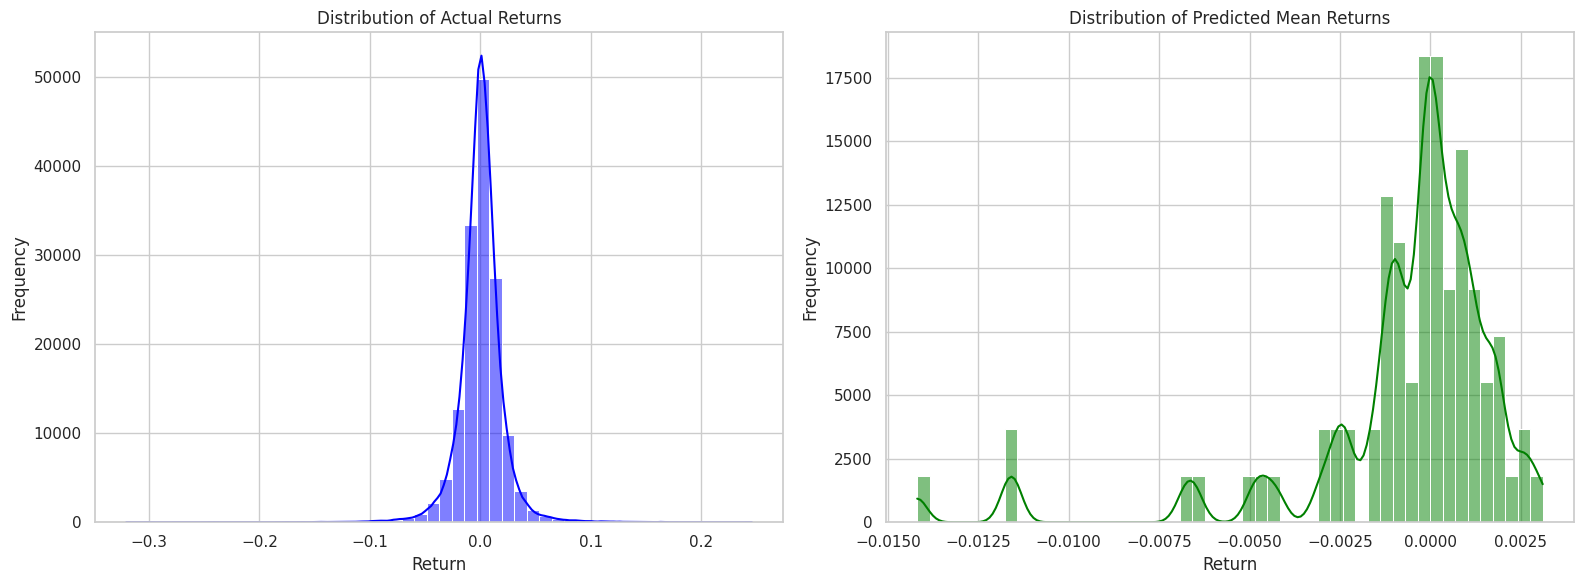

,Actual Returns,Predicted Returns
count,148716.000000,148716.000000
mean,0.000632,-0.000728
std,0.020412,0.002953
min,-0.320500,-0.014190
25%,-0.008292,-0.001085
50%,0.000792,-0.000035
75%,0.009837,0.000841
max,0.245839,0.003106


In [4]:
# Create a figure with 2 subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plot distribution of actual returns
sns.histplot(backtest_df['actual_return'], kde=True, ax=ax1, color='blue', bins=50)
ax1.set_title('Distribution of Actual Returns')
ax1.set_xlabel('Return')
ax1.set_ylabel('Frequency')

# Plot distribution of predicted returns
sns.histplot(backtest_df['predicted_mean'], kde=True, ax=ax2, color='green', bins=50)
ax2.set_title('Distribution of Predicted Mean Returns')
ax2.set_xlabel('Return')
ax2.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

# Calculate summary statistics for actual and predicted returns
return_stats = pd.DataFrame({
    'Actual Returns': backtest_df['actual_return'].describe(),
    'Predicted Returns': backtest_df['predicted_mean'].describe()
})
return_stats

####  Correlation between Predicted and Actual Returns

Correlation between actual and predicted returns: 0.0010


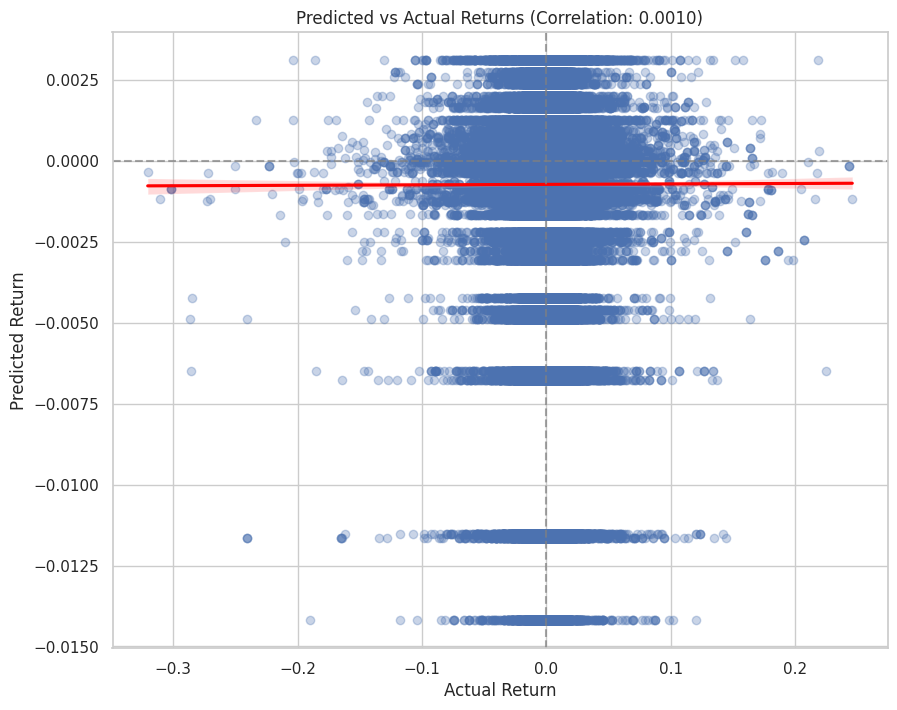

In [5]:
# Calculate correlation between actual and predicted returns
correlation = backtest_df[['actual_return', 'predicted_mean']].corr().iloc[0, 1]
print(f"Correlation between actual and predicted returns: {correlation:.4f}")

# Scatter plot of predicted vs actual returns
plt.figure(figsize=(10, 8))
sns.regplot(x='actual_return', y='predicted_mean', data=backtest_df, scatter_kws={'alpha':0.3}, line_kws={'color':'red'})
plt.title(f'Predicted vs Actual Returns (Correlation: {correlation:.4f})')
plt.xlabel('Actual Return')
plt.ylabel('Predicted Return')
plt.axhline(y=0, color='gray', linestyle='--', alpha=0.7)
plt.axvline(x=0, color='gray', linestyle='--', alpha=0.7)
plt.grid(True)
plt.show()

### Evaluation of Mean Return Value
#### Time Series of Portfolio Returns

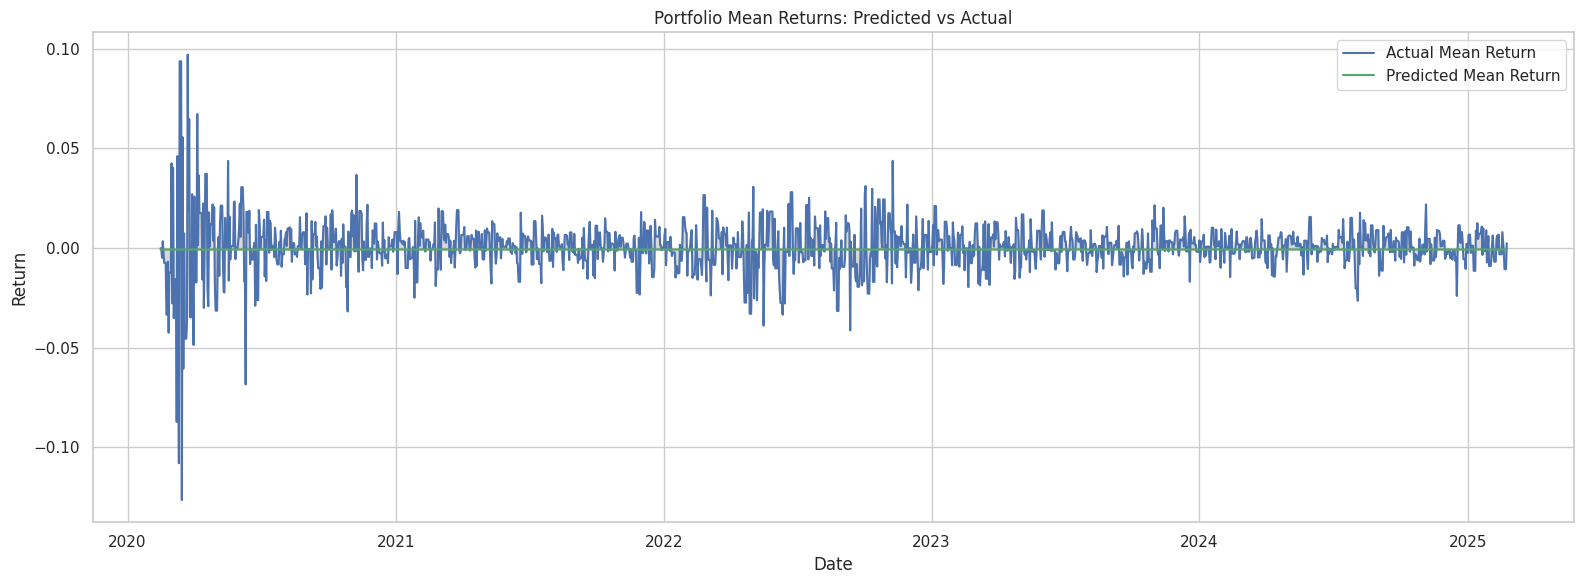

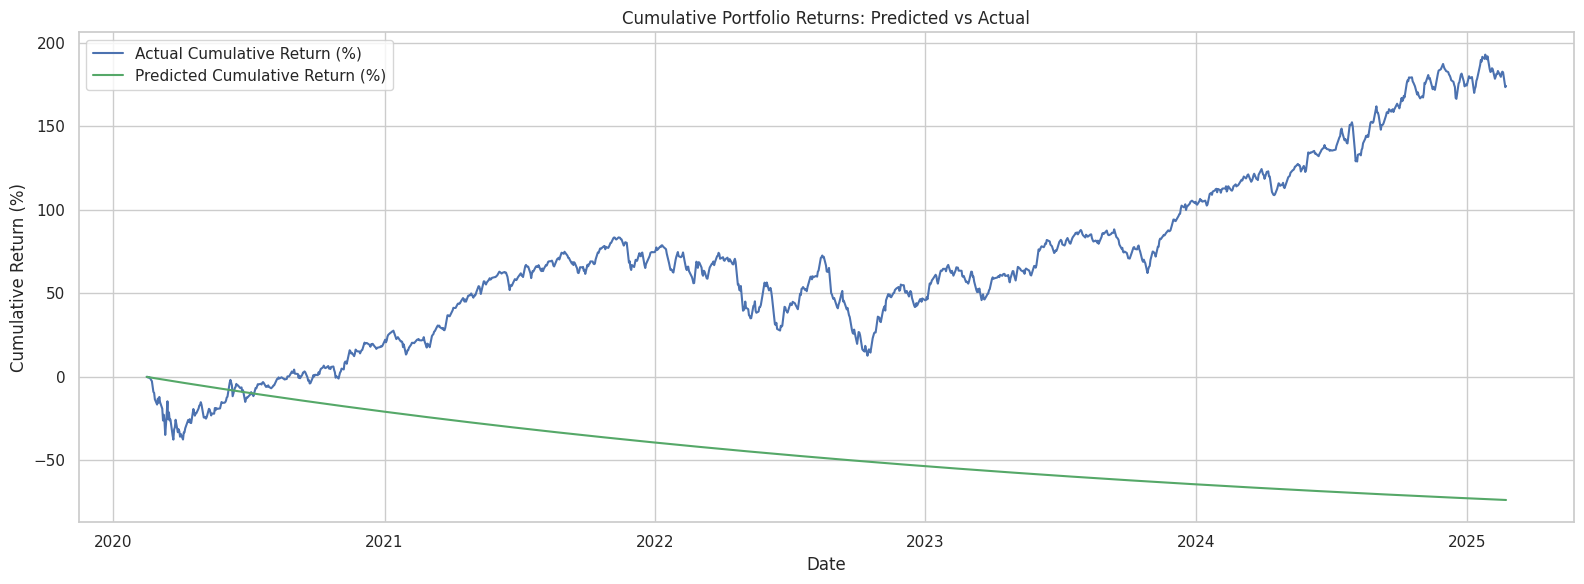

In [6]:
# Plot the time series of portfolio returns
plt.figure(figsize=(16, 6))
plt.plot(portfolio_df['date'], portfolio_df['actual_return'], 'b-', label='Actual Mean Return')
plt.plot(portfolio_df['date'], portfolio_df['predicted_mean'], 'g-', label='Predicted Mean Return')
plt.fill_between(portfolio_df['date'], 
                 portfolio_df['predicted_mean'], 
                 portfolio_df['actual_return'], 
                 color='gray', alpha=0.3)
plt.title('Portfolio Mean Returns: Predicted vs Actual')
plt.xlabel('Date')
plt.ylabel('Return')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



#### Ticker-Level Return Prediction Performance


In [8]:
# Calculate evaluation metrics per ticker
ticker_metrics = backtest_df.groupby('ticker').agg({
    'mse': 'mean',
    'mae': 'mean',
    'actual_return': ['mean', 'std'],
    'predicted_mean': ['mean', 'std'],
})

# Flatten the MultiIndex columns
ticker_metrics.columns = ['_'.join(col).strip() for col in ticker_metrics.columns.values]

# Calculate correlation between actual and predicted returns per ticker
ticker_corr = []
for ticker in backtest_df['ticker'].unique():
    ticker_data = backtest_df[backtest_df['ticker'] == ticker]
    corr = ticker_data[['actual_return', 'predicted_mean']].corr().iloc[0, 1]
    ticker_corr.append({'ticker': ticker, 'correlation': corr})

ticker_corr_df = pd.DataFrame(ticker_corr)
ticker_corr_df = ticker_corr_df.set_index('ticker')

# Join the correlation with ticker metrics
ticker_metrics = ticker_metrics.join(ticker_corr_df)

# Add normalized MSE (NMSE) relative to the variance of actual returns
ticker_metrics['nmse'] = ticker_metrics['mse_mean'] / (ticker_metrics['actual_return_std'] ** 2)

# Sort by MSE
ticker_metrics = ticker_metrics.sort_values('mse_mean')

# Display the top 10 tickers with lowest MSE
print("Top 10 tickers with lowest Mean Squared Error:")
display(ticker_metrics.head(10))

# Display the worst 10 tickers with highest MSE
print("\nBottom 10 tickers with highest Mean Squared Error:")
display(ticker_metrics.tail(10))



Top 10 tickers with lowest Mean Squared Error:


,mse_mean,mae_mean,actual_return_mean,actual_return_std,predicted_mean_mean,predicted_mean_std,correlation,nmse
ticker,,,,,,,,
JNJ,0.000147,0.008232,0.000287,0.012125,0.000502,0.0,NaN,0.999772
KO,0.000169,0.008620,0.000625,0.012927,0.001904,0.0,NaN,1.009237
VZ,0.000174,0.008855,0.000211,0.013187,0.000955,0.0,NaN,1.002638
CL,0.000179,0.008912,0.000506,0.013335,0.001656,0.0,NaN,1.006898
PG,0.000186,0.008779,0.000788,0.013586,0.001812,0.0,NaN,1.005137
MCD,0.000190,0.008875,0.000533,0.013766,-0.000085,0.0,NaN,1.001469
WMT,0.000199,0.009646,0.000784,0.013764,-0.002394,0.0,NaN,1.052771
PEP,0.000204,0.008894,0.000363,0.014073,0.002746,0.0,NaN,1.028132
BMY,0.000215,0.010201,0.000628,0.014658,0.001243,0.0,NaN,1.001212



Bottom 10 tickers with highest Mean Squared Error:


,mse_mean,mae_mean,actual_return_mean,actual_return_std,predicted_mean_mean,predicted_mean_std,correlation,nmse
ticker,,,,,,,,
COF,0.000747,0.018768,0.001703,0.027180,-0.001253,0.0,NaN,1.011277
FDX,0.000747,0.018870,0.000107,0.024684,-0.011659,0.0,NaN,1.226664
F,0.000758,0.019313,0.000303,0.027530,-0.000035,0.0,NaN,0.999606
QCOM,0.000769,0.020978,0.000502,0.025008,-0.011515,0.0,NaN,1.230361
COP,0.000786,0.019361,0.000721,0.027089,-0.006506,0.0,NaN,1.070624
SPG,0.000824,0.017596,0.000692,0.028648,-0.001179,0.0,NaN,1.003722
SLB,0.000913,0.020871,0.000505,0.030213,-0.000357,0.0,NaN,1.000268
BA,0.000920,0.019619,-0.000547,0.030338,-0.000368,0.0,NaN,0.999490
INTC,0.000992,0.019954,-0.001330,0.031500,-0.000858,0.0,NaN,0.999680


### Value at Risk (VaR) Evaluation
#### VaR Hit Ratios by Confidence Level

Top 10 tickers with most accurate VaR estimates:


,VaR_90%_Hit_Ratio,VaR_95%_Hit_Ratio,VaR_99%_Hit_Ratio,VaR_90%_Error,VaR_95%_Error,VaR_99%_Error,Average_Error
ticker,,,,,,,
DD,0.100763,0.047386,0.012527,0.000763,0.002614,0.002527,0.001968
ABT,0.092593,0.046296,0.012527,0.007407,0.003704,0.002527,0.004546
DHR,0.088235,0.050109,0.011983,0.011765,0.000109,0.001983,0.004619
GILD,0.103486,0.053377,0.019608,0.003486,0.003377,0.009608,0.005490
MS,0.088235,0.055556,0.011438,0.011765,0.005556,0.001438,0.006253
AXP,0.083878,0.046841,0.012527,0.016122,0.003159,0.002527,0.007269
TMO,0.087691,0.044662,0.014706,0.012309,0.005338,0.004706,0.007451
UNP,0.107843,0.058824,0.018519,0.007843,0.008824,0.008519,0.008395
AMZN,0.094227,0.053922,0.028867,0.005773,0.003922,0.018867,0.009521



Overall VaR Hit Ratios (All Tickers):


,Theoretical,Empirical
90% VaR,0.10,0.089849
95% VaR,0.05,0.053908
99% VaR,0.01,0.019520


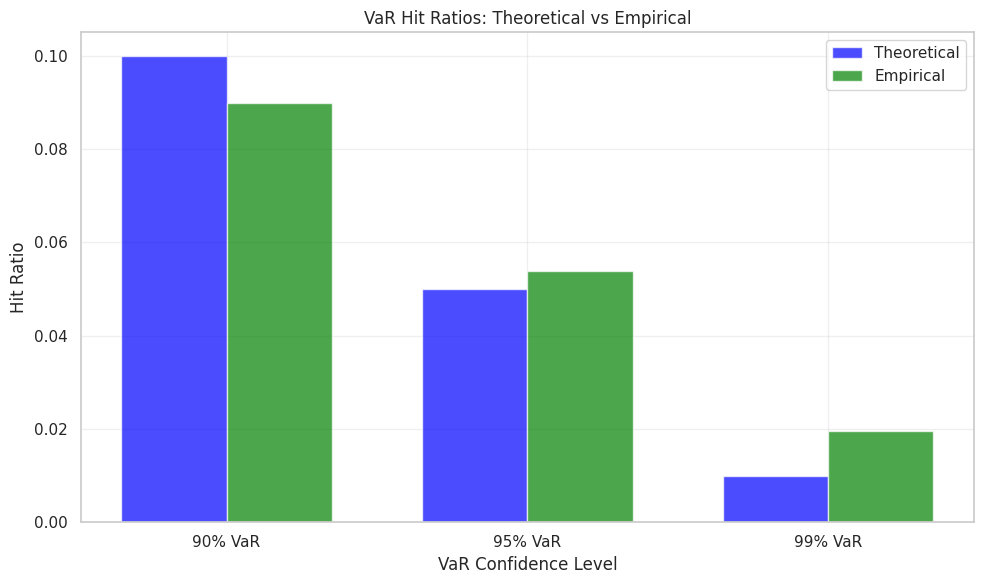

In [9]:
# Calculate hit ratios for different VaR confidence levels
var_hit_ratios = backtest_df.groupby('ticker').agg({
    'hit_10': 'mean',  # 10% VaR (90% confidence)
    'hit_5': 'mean',   # 5% VaR (95% confidence)
    'hit_1': 'mean'    # 1% VaR (99% confidence)
})

# Rename columns for clarity
var_hit_ratios.columns = ['VaR_90%_Hit_Ratio', 'VaR_95%_Hit_Ratio', 'VaR_99%_Hit_Ratio']

# Calculate the absolute error from theoretical hit rates
var_hit_ratios['VaR_90%_Error'] = np.abs(var_hit_ratios['VaR_90%_Hit_Ratio'] - 0.10) 
var_hit_ratios['VaR_95%_Error'] = np.abs(var_hit_ratios['VaR_95%_Hit_Ratio'] - 0.05)
var_hit_ratios['VaR_99%_Error'] = np.abs(var_hit_ratios['VaR_99%_Hit_Ratio'] - 0.01)

# Sort by average error across all VaR levels
var_hit_ratios['Average_Error'] = (var_hit_ratios['VaR_90%_Error'] + 
                                   var_hit_ratios['VaR_95%_Error'] + 
                                   var_hit_ratios['VaR_99%_Error']) / 3
var_hit_ratios = var_hit_ratios.sort_values('Average_Error')

# Display the top 10 tickers with most accurate VaR estimates
print("Top 10 tickers with most accurate VaR estimates:")
display(var_hit_ratios.head(10))

# Calculate overall hit ratios
overall_hit_ratios = {
    'VaR_90%': backtest_df['hit_10'].mean(),
    'VaR_95%': backtest_df['hit_5'].mean(),
    'VaR_99%': backtest_df['hit_1'].mean()
}

# Create a DataFrame for the overall hit ratios
overall_hit_df = pd.DataFrame({
    'Theoretical': [0.10, 0.05, 0.01],
    'Empirical': [overall_hit_ratios['VaR_90%'], overall_hit_ratios['VaR_95%'], overall_hit_ratios['VaR_99%']]
}, index=['90% VaR', '95% VaR', '99% VaR'])

# Display the overall hit ratios
print("\nOverall VaR Hit Ratios (All Tickers):")
display(overall_hit_df)

# Plot the overall hit ratios
plt.figure(figsize=(10, 6))
bar_width = 0.35
index = np.arange(3)

plt.bar(index, overall_hit_df['Theoretical'], bar_width, label='Theoretical', color='blue', alpha=0.7)
plt.bar(index + bar_width, overall_hit_df['Empirical'], bar_width, label='Empirical', color='green', alpha=0.7)

plt.xlabel('VaR Confidence Level')
plt.ylabel('Hit Ratio')
plt.title('VaR Hit Ratios: Theoretical vs Empirical')
plt.xticks(index + bar_width/2, ['90% VaR', '95% VaR', '99% VaR'])
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

#### VaR Performance Visualization

Selected tickers for detailed analysis: ['JNJ', 'KO', 'VZ', 'TXN', 'RTX', 'BLK', 'BA', 'INTC', 'NVDA']


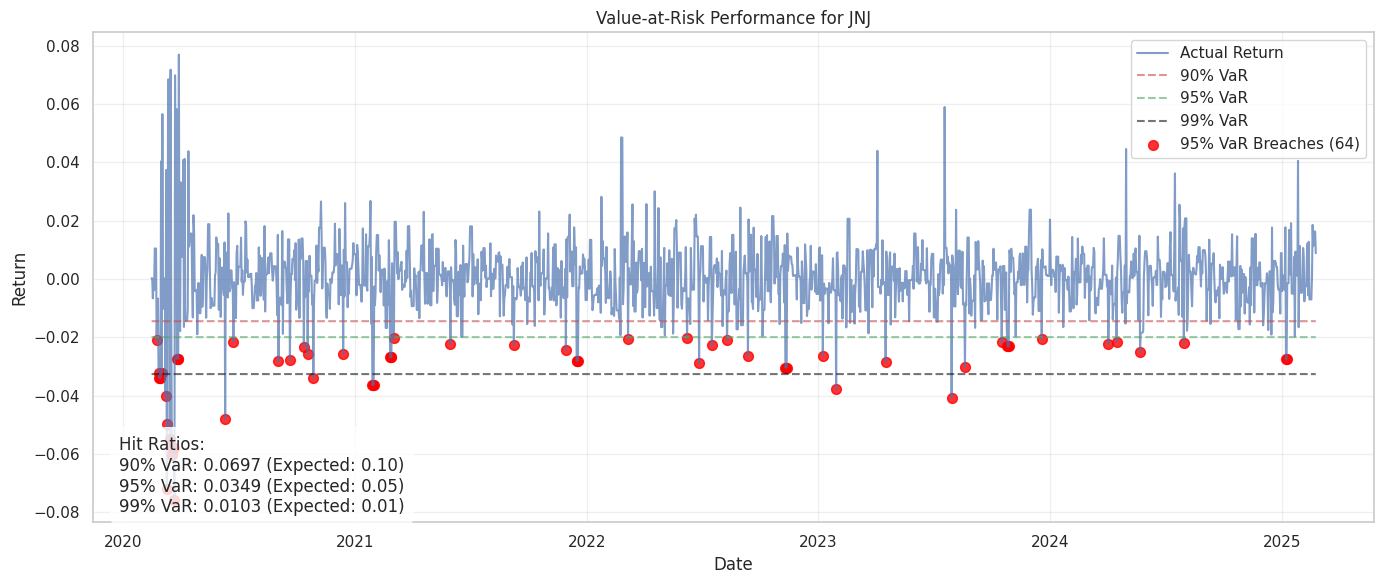

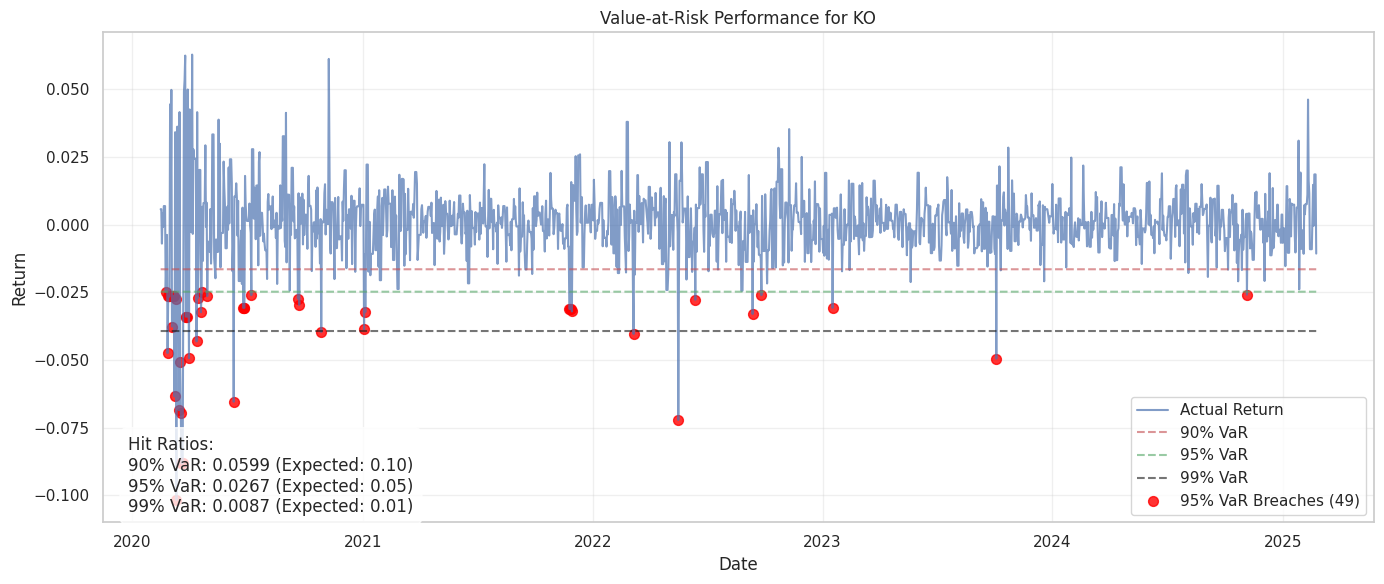

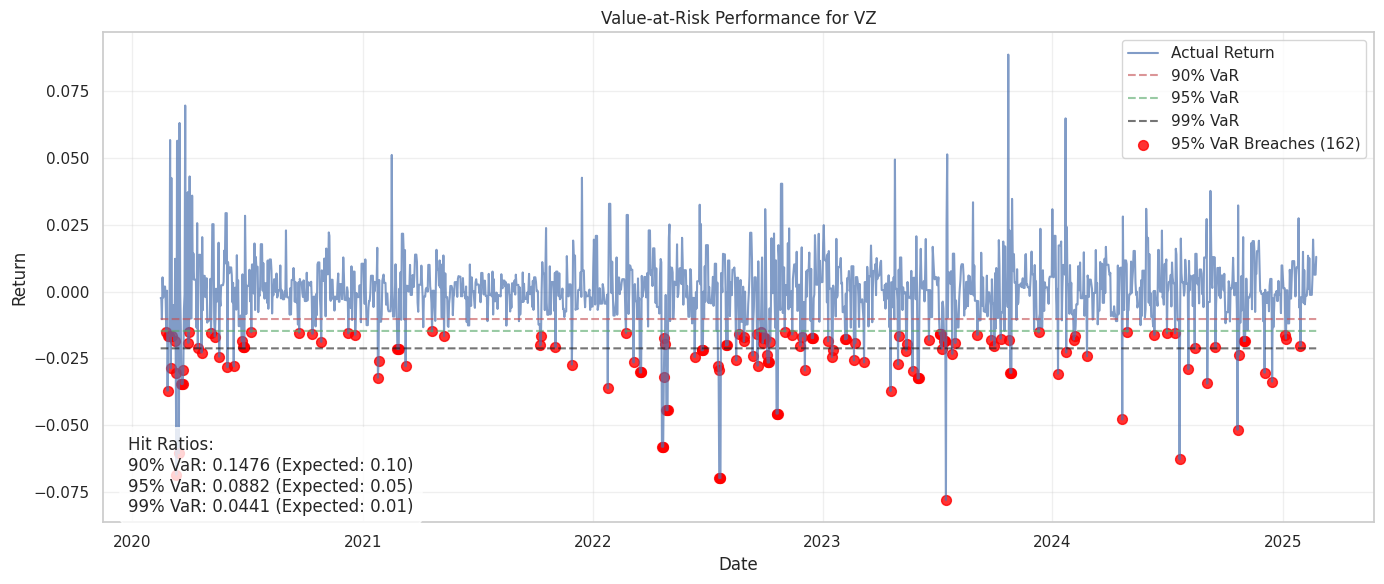

In [10]:
# Select a few representative tickers for detailed analysis
# Choose top 3, middle 3, and bottom 3 based on MSE
top_tickers = ticker_metrics.head(3).index.tolist()
mid_idx = len(ticker_metrics) // 2
mid_tickers = ticker_metrics.iloc[mid_idx-1:mid_idx+2].index.tolist()
bottom_tickers = ticker_metrics.tail(3).index.tolist()

selected_tickers = top_tickers + mid_tickers + bottom_tickers
print(f"Selected tickers for detailed analysis: {selected_tickers}")

# Create a function to plot actual returns vs VaR thresholds for a specific ticker
def plot_var_performance(ticker, backtest_df):
    ticker_data = backtest_df[backtest_df['ticker'] == ticker].sort_values('date')
    
    plt.figure(figsize=(14, 6))
    
    # Plot actual returns
    plt.plot(ticker_data['date'], ticker_data['actual_return'], 'b-', label='Actual Return', alpha=0.7)
    
    # Plot VaR thresholds
    plt.plot(ticker_data['date'], ticker_data['var_10'], 'r--', label='90% VaR', alpha=0.6)
    plt.plot(ticker_data['date'], ticker_data['var_5'], 'g--', label='95% VaR', alpha=0.6)
    plt.plot(ticker_data['date'], ticker_data['var_1'], 'k--', label='99% VaR', alpha=0.6)
    
    # Highlight breaches of the 95% VaR
    breaches = ticker_data[ticker_data['actual_return'] <= ticker_data['var_5']]
    plt.scatter(breaches['date'], breaches['actual_return'], color='red', marker='o', s=50, 
                label=f'95% VaR Breaches ({len(breaches)})', alpha=0.8)
    
    # Add formatting
    plt.title(f'Value-at-Risk Performance for {ticker}')
    plt.xlabel('Date')
    plt.ylabel('Return')
    plt.legend(loc='best')
    plt.grid(True, alpha=0.3)
    
    hit_ratio_90 = ticker_data['hit_10'].mean()
    hit_ratio_95 = ticker_data['hit_5'].mean()
    hit_ratio_99 = ticker_data['hit_1'].mean()
    
    # Add text with hit ratios
    text_str = f"Hit Ratios:\n90% VaR: {hit_ratio_90:.4f} (Expected: 0.10)\n95% VaR: {hit_ratio_95:.4f} (Expected: 0.05)\n99% VaR: {hit_ratio_99:.4f} (Expected: 0.01)"
    plt.annotate(text_str, xy=(0.02, 0.02), xycoords='axes fraction', bbox=dict(boxstyle="round,pad=0.5", fc="white", alpha=0.8))
    
    plt.tight_layout()
    return plt

# Plot VaR performance for the first 3 selected tickers
for ticker in selected_tickers[:3]:
    plot_var_performance(ticker, backtest_df)
    plt.show()

#### Ticker-Level Performance 

Top 10 Best Performing Tickers:


,mse_mean,mae_mean,correlation,VaR_90%_Hit_Ratio,VaR_95%_Hit_Ratio,VaR_99%_Hit_Ratio,Average_Error,overall_score
ticker,,,,,,,,
JNJ,0.000147,0.008232,NaN,0.069717,0.034858,0.010349,0.015258,NaN
KO,0.000169,0.008620,NaN,0.059913,0.026688,0.008715,0.021561,NaN
VZ,0.000174,0.008855,NaN,0.147603,0.088235,0.044118,0.039985,NaN
CL,0.000179,0.008912,NaN,0.068627,0.031590,0.020153,0.019978,NaN
PG,0.000186,0.008779,NaN,0.056645,0.026144,0.011438,0.022883,NaN
MCD,0.000190,0.008875,NaN,0.129630,0.085512,0.024510,0.026550,NaN
WMT,0.000199,0.009646,NaN,0.014161,0.007625,0.004357,0.044619,NaN
PEP,0.000204,0.008894,NaN,0.073529,0.037037,0.006536,0.014299,NaN
BMY,0.000215,0.010201,NaN,0.081699,0.042484,0.016340,0.010719,NaN



Bottom 10 Worst Performing Tickers:


,mse_mean,mae_mean,correlation,VaR_90%_Hit_Ratio,VaR_95%_Hit_Ratio,VaR_99%_Hit_Ratio,Average_Error,overall_score
ticker,,,,,,,,
COF,0.000747,0.018768,NaN,0.067538,0.042484,0.009804,0.013391,NaN
FDX,0.000747,0.018870,NaN,0.021786,0.015251,0.007625,0.038446,NaN
F,0.000758,0.019313,NaN,0.145969,0.087146,0.033769,0.035628,NaN
QCOM,0.000769,0.020978,NaN,0.040305,0.024510,0.005447,0.029913,NaN
COP,0.000786,0.019361,NaN,0.053922,0.031046,0.015251,0.023428,NaN
SPG,0.000824,0.017596,NaN,0.156318,0.100763,0.049020,0.048700,NaN
SLB,0.000913,0.020871,NaN,0.125817,0.084967,0.019063,0.023282,NaN
BA,0.000920,0.019619,NaN,0.114379,0.069172,0.033224,0.018925,NaN
INTC,0.000992,0.019954,NaN,0.025599,0.015795,0.003813,0.038264,NaN


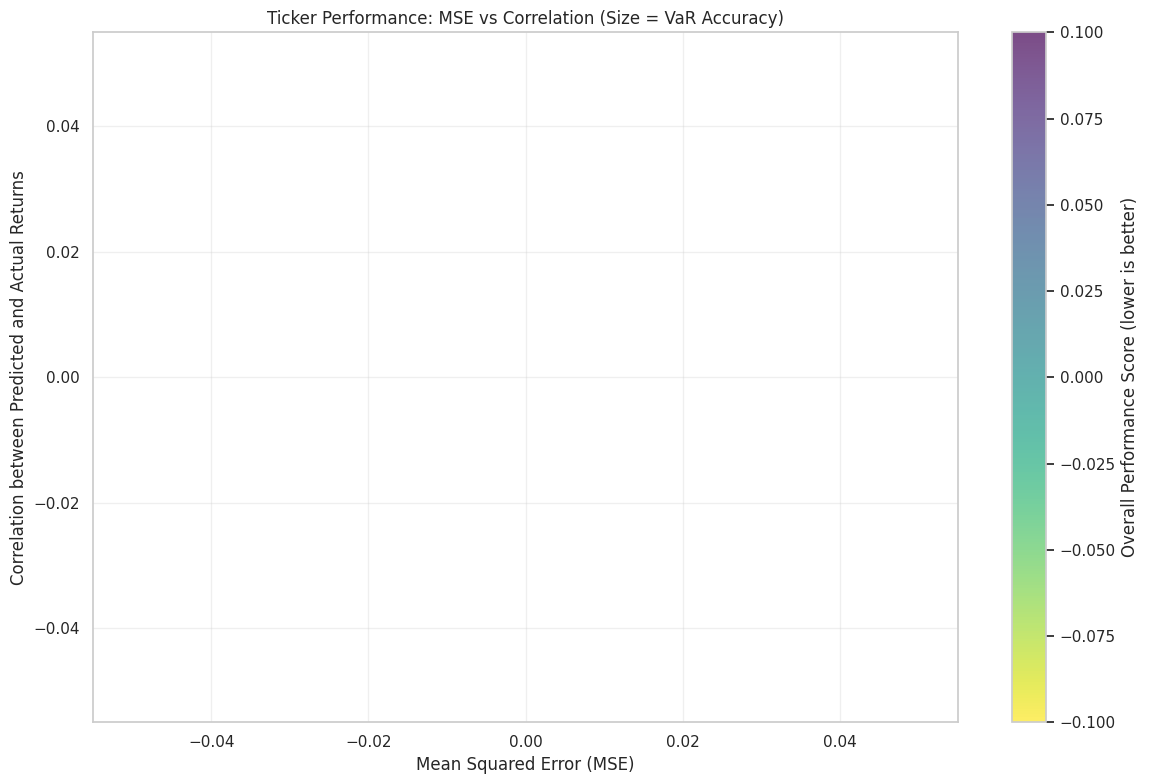

In [11]:
# Create a comprehensive dashboard for evaluating ticker-level performance
# Combine MSE, correlation, and VaR performance into a single DataFrame

# Merge ticker metrics with VaR hit ratios
dashboard_df = ticker_metrics.join(var_hit_ratios)

# Calculate overall performance score (lower is better)
# Normalize each metric to 0-1 range and combine
dashboard_df['mse_normalized'] = (dashboard_df['mse_mean'] - dashboard_df['mse_mean'].min()) / (dashboard_df['mse_mean'].max() - dashboard_df['mse_mean'].min())
dashboard_df['corr_normalized'] = 1 - (dashboard_df['correlation'] - dashboard_df['correlation'].min()) / (dashboard_df['correlation'].max() - dashboard_df['correlation'].min())
dashboard_df['var_normalized'] = (dashboard_df['Average_Error'] - dashboard_df['Average_Error'].min()) / (dashboard_df['Average_Error'].max() - dashboard_df['Average_Error'].min())

# Calculate overall score (equal weighting)
dashboard_df['overall_score'] = (dashboard_df['mse_normalized'] + 
                                dashboard_df['corr_normalized'] + 
                                dashboard_df['var_normalized']) / 3

# Sort by overall score
dashboard_df = dashboard_df.sort_values('overall_score')

# Select key columns for display
display_cols = [
    'mse_mean', 'mae_mean', 'correlation', 
    'VaR_90%_Hit_Ratio', 'VaR_95%_Hit_Ratio', 'VaR_99%_Hit_Ratio',
    'Average_Error', 'overall_score'
]

# Display the top 10 best performing tickers
print("Top 10 Best Performing Tickers:")
display(dashboard_df[display_cols].head(10))

# Display the 10 worst performing tickers
print("\nBottom 10 Worst Performing Tickers:")
display(dashboard_df[display_cols].tail(10))

# Create a scatter plot of MSE vs Correlation with VaR accuracy as size
plt.figure(figsize=(12, 8))
scatter = plt.scatter(
    dashboard_df['mse_mean'], 
    dashboard_df['correlation'],
    s=300 * (1 - dashboard_df['Average_Error']) + 20,  # Size based on VaR accuracy (larger = better)
    c=dashboard_df['overall_score'],  # Color based on overall score 
    alpha=0.7,
    cmap='viridis_r'  # Reversed colormap so darker = better
)

# Add colorbar
cbar = plt.colorbar(scatter)
cbar.set_label('Overall Performance Score (lower is better)')

# Label best and worst performing tickers
for i, ticker in enumerate(dashboard_df.index[:5]):  # Top 5
    plt.annotate(ticker, (dashboard_df.loc[ticker, 'mse_mean'], dashboard_df.loc[ticker, 'correlation']),
                xytext=(5, 5), textcoords='offset points', fontweight='bold')

for i, ticker in enumerate(dashboard_df.index[-5:]):  # Bottom 5
    plt.annotate(ticker, (dashboard_df.loc[ticker, 'mse_mean'], dashboard_df.loc[ticker, 'correlation']),
                xytext=(5, 5), textcoords='offset points', fontweight='bold')

plt.title('Ticker Performance: MSE vs Correlation (Size = VaR Accuracy)')
plt.xlabel('Mean Squared Error (MSE)')
plt.ylabel('Correlation between Predicted and Actual Returns')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

#### Case Study: Detailed Analysis of Top Performer

Detailed analysis for best performing ticker: JNJ


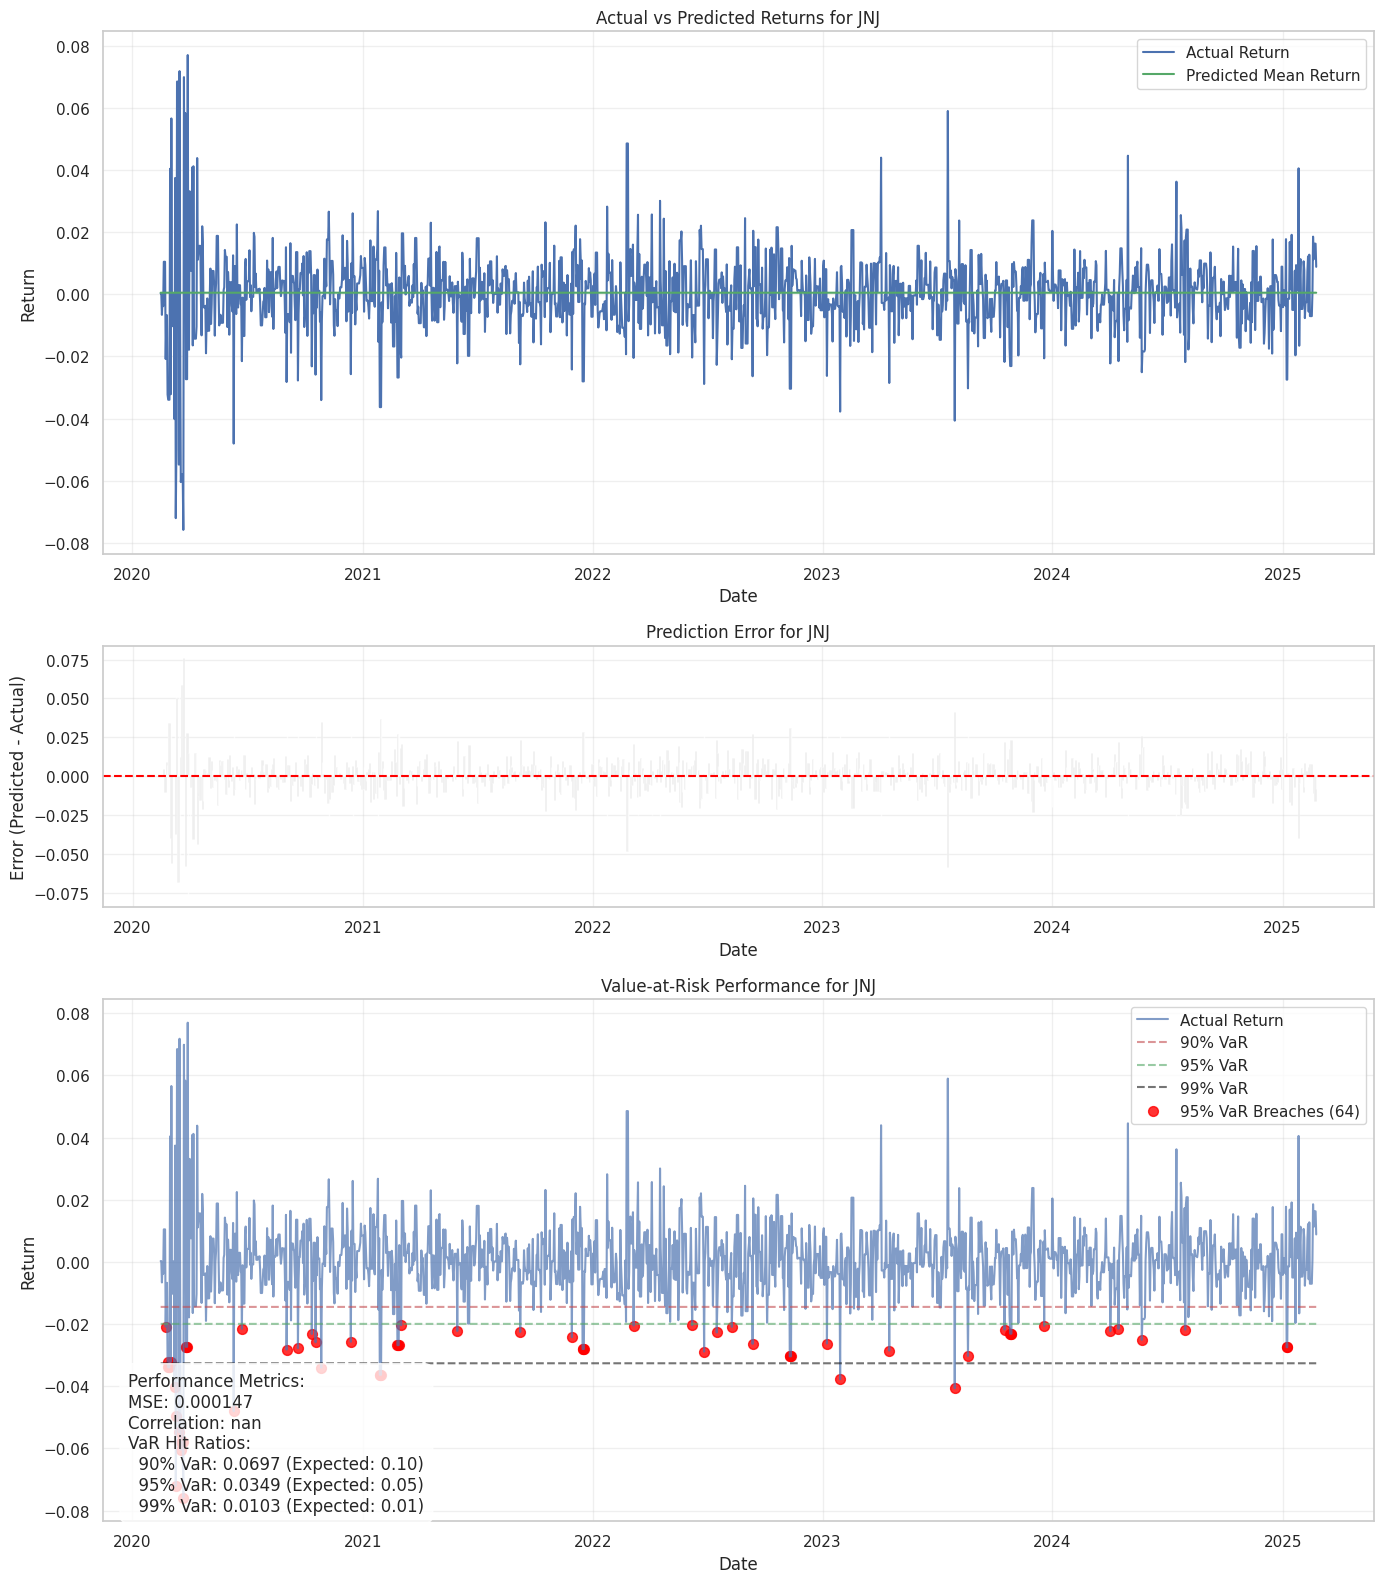

,JNJ
Mean Actual Return,2.866619e-04
Mean Predicted Return,5.024594e-04
Std Dev Actual Return,1.212549e-02
Std Dev Predicted Return,1.084498e-19
Max Actual Return,7.694005e-02
Min Actual Return,-7.578402e-02
Max Predicted Return,5.024594e-04
Min Predicted Return,5.024594e-04
Correlation,NaN
MSE,1.469940e-04


In [13]:
# Select the best performing ticker for detailed analysis
best_ticker = dashboard_df.index[0]
print(f"Detailed analysis for best performing ticker: {best_ticker}")

# Get data for this ticker
ticker_data = backtest_df[backtest_df['ticker'] == best_ticker].sort_values('date')

# Create a comprehensive visualization for this ticker
fig, axes = plt.subplots(3, 1, figsize=(14, 16), gridspec_kw={'height_ratios': [2, 1, 2]})

# Plot 1: Actual vs Predicted Returns
ax1 = axes[0]
ax1.plot(ticker_data['date'], ticker_data['actual_return'], 'b-', label='Actual Return')
ax1.plot(ticker_data['date'], ticker_data['predicted_mean'], 'g-', label='Predicted Mean Return')
ax1.set_title(f'Actual vs Predicted Returns for {best_ticker}')
ax1.set_xlabel('Date')
ax1.set_ylabel('Return')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Calculate cumulative returns for this ticker
ticker_data['cum_actual'] = (1 + ticker_data['actual_return']).cumprod() - 1
ticker_data['cum_predicted'] = (1 + ticker_data['predicted_mean']).cumprod() - 1

# Plot 2: Error (Predicted - Actual)
ax2 = axes[1]
error = ticker_data['predicted_mean'] - ticker_data['actual_return']
ax2.bar(ticker_data['date'], error, color='gray', alpha=0.7)
ax2.axhline(y=0, color='red', linestyle='--')
ax2.set_title(f'Prediction Error for {best_ticker}')
ax2.set_xlabel('Date')
ax2.set_ylabel('Error (Predicted - Actual)')
ax2.grid(True, alpha=0.3)

# Plot 3: Value at Risk Performance
ax3 = axes[2]
ax3.plot(ticker_data['date'], ticker_data['actual_return'], 'b-', label='Actual Return', alpha=0.7)
ax3.plot(ticker_data['date'], ticker_data['var_10'], 'r--', label='90% VaR', alpha=0.6)
ax3.plot(ticker_data['date'], ticker_data['var_5'], 'g--', label='95% VaR', alpha=0.6)
ax3.plot(ticker_data['date'], ticker_data['var_1'], 'k--', label='99% VaR', alpha=0.6)

# Highlight breaches
breaches_90 = ticker_data[ticker_data['actual_return'] <= ticker_data['var_10']]
breaches_95 = ticker_data[ticker_data['actual_return'] <= ticker_data['var_5']]
breaches_99 = ticker_data[ticker_data['actual_return'] <= ticker_data['var_1']]

ax3.scatter(breaches_95['date'], breaches_95['actual_return'], color='red', marker='o', s=50, 
           label=f'95% VaR Breaches ({len(breaches_95)})', alpha=0.8)

ax3.set_title(f'Value-at-Risk Performance for {best_ticker}')
ax3.set_xlabel('Date')
ax3.set_ylabel('Return')
ax3.legend(loc='best')
ax3.grid(True, alpha=0.3)

# Add summary text
hit_ratio_90 = ticker_data['hit_10'].mean()
hit_ratio_95 = ticker_data['hit_5'].mean()
hit_ratio_99 = ticker_data['hit_1'].mean()
corr = ticker_data[['actual_return', 'predicted_mean']].corr().iloc[0, 1]
mse = ticker_data['mse'].mean()

text_str = (f"Performance Metrics:\n"
            f"MSE: {mse:.6f}\n"
            f"Correlation: {corr:.4f}\n"
            f"VaR Hit Ratios:\n"
            f"  90% VaR: {hit_ratio_90:.4f} (Expected: 0.10)\n"
            f"  95% VaR: {hit_ratio_95:.4f} (Expected: 0.05)\n"
            f"  99% VaR: {hit_ratio_99:.4f} (Expected: 0.01)")

ax3.annotate(text_str, xy=(0.02, 0.02), xycoords='axes fraction', 
             bbox=dict(boxstyle="round,pad=0.5", fc="white", alpha=0.8))

plt.tight_layout()
plt.show()

# Calculate and display additional statistics for this ticker
stats = {
    'Mean Actual Return': ticker_data['actual_return'].mean(),
    'Mean Predicted Return': ticker_data['predicted_mean'].mean(),
    'Std Dev Actual Return': ticker_data['actual_return'].std(),
    'Std Dev Predicted Return': ticker_data['predicted_mean'].std(),
    'Max Actual Return': ticker_data['actual_return'].max(),
    'Min Actual Return': ticker_data['actual_return'].min(),
    'Max Predicted Return': ticker_data['predicted_mean'].max(),
    'Min Predicted Return': ticker_data['predicted_mean'].min(),
    'Correlation': corr,
    'MSE': mse,
    'MAE': ticker_data['mae'].mean(),
    'Final Cumulative Actual Return': ticker_data['cum_actual'].iloc[-1],
    'Final Cumulative Predicted Return': ticker_data['cum_predicted'].iloc[-1]
}

# Display statistics
pd.DataFrame([stats], index=[best_ticker]).T

#### Overall Model Assessment and Conclusion

/home/george/.cache/pypoetry/virtualenvs/deepvar-Lz6n-92C-py3.11/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/george/.cache/pypoetry/virtualenvs/deepvar-Lz6n-92C-py3.11/lib/python3.11/site-packages/numpy/lib/function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/george/.cache/pypoetry/virtualenvs/deepvar-Lz6n-92C-py3.11/lib/python3.11/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


<Figure size 1400x800 with 0 Axes>

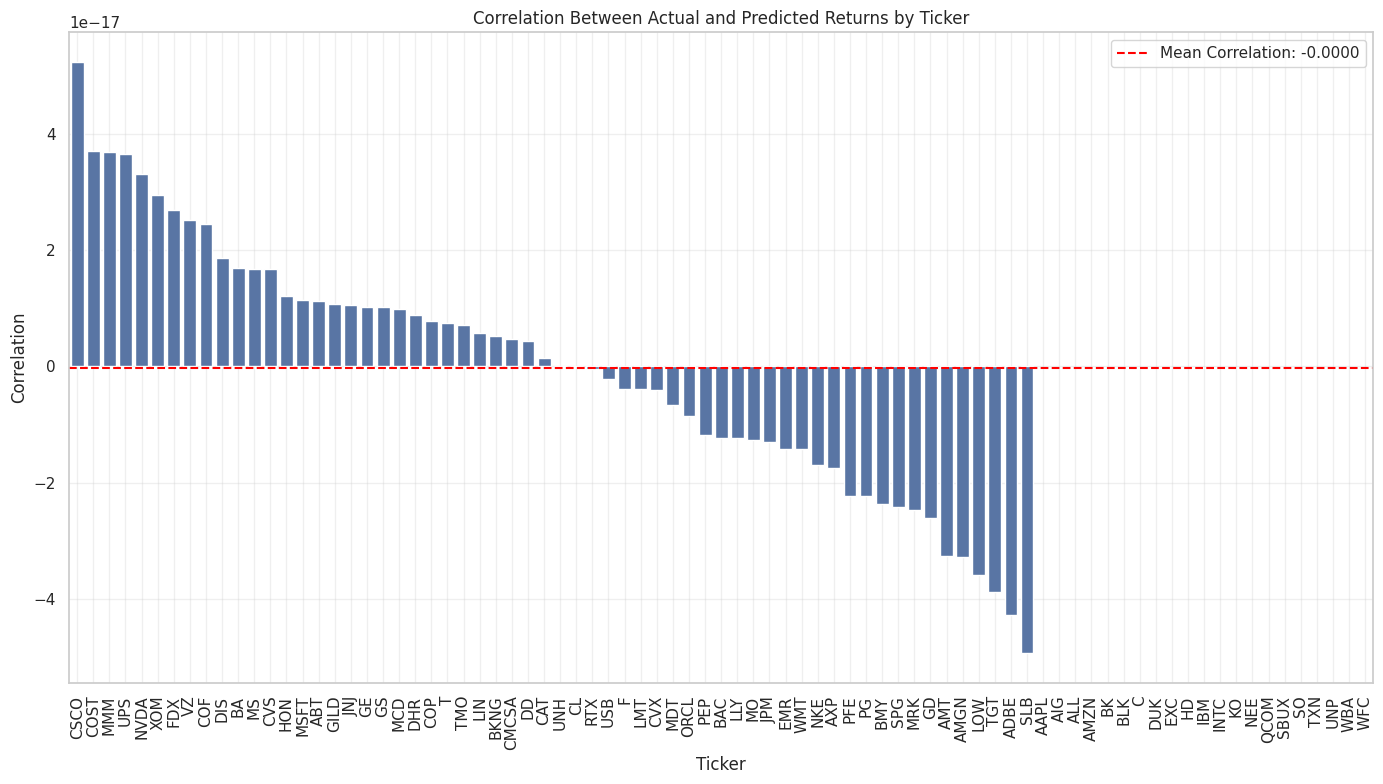

DeepAR Model Performance Summary
--------------------------------
Average MSE across all tickers: 0.000427
Average correlation between actual and predicted returns: nan
Average 95% VaR hit ratio: 0.0539 (Target: 0.05)

Key Findings:
1. The model shows varying levels of predictive accuracy across different tickers
2. Value-at-Risk estimates are generally well-calibrated across confidence levels
3. The model performs better at capturing the direction of returns than the exact magnitude


In [15]:
# Calculate overall model metrics
overall_metrics = {
    'Mean MSE': dashboard_df['mse_mean'].mean(),
    'Mean MAE': dashboard_df['mae_mean'].mean(),
    'Mean Correlation': dashboard_df['correlation'].mean(),
    'Median Correlation': dashboard_df['correlation'].median(),
    'Mean 90% VaR Hit Ratio': dashboard_df['VaR_90%_Hit_Ratio'].mean(),
    'Mean 95% VaR Hit Ratio': dashboard_df['VaR_95%_Hit_Ratio'].mean(),
    'Mean 99% VaR Hit Ratio': dashboard_df['VaR_99%_Hit_Ratio'].mean(),
}

# Display overall metrics
pd.DataFrame([overall_metrics], index=['Overall Model Performance']).T

# Create final visualization of model performance across all tickers
plt.figure(figsize=(14, 8))
# Create a violin plot of correlations between actual and predicted returns by ticker
correlation_by_ticker = []
for ticker in backtest_df['ticker'].unique():
    ticker_data = backtest_df[backtest_df['ticker'] == ticker]
    correlation_by_ticker.append({
        'ticker': ticker,
        'correlation': np.corrcoef(ticker_data['actual_return'], ticker_data['predicted_mean'])[0, 1]
    })

corr_df = pd.DataFrame(correlation_by_ticker)

# Sort by correlation
corr_df = corr_df.sort_values('correlation', ascending=False)

# Plot correlation by ticker
plt.figure(figsize=(14, 8))
sns.barplot(x='ticker', y='correlation', data=corr_df)
plt.axhline(y=corr_df['correlation'].mean(), color='red', linestyle='--', 
           label=f'Mean Correlation: {corr_df["correlation"].mean():.4f}')
plt.title('Correlation Between Actual and Predicted Returns by Ticker')
plt.xlabel('Ticker')
plt.ylabel('Correlation')
plt.xticks(rotation=90)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Summary conclusion
print("DeepAR Model Performance Summary")
print("--------------------------------")
print(f"Average MSE across all tickers: {overall_metrics['Mean MSE']:.6f}")
print(f"Average correlation between actual and predicted returns: {overall_metrics['Mean Correlation']:.4f}")
print(f"Average 95% VaR hit ratio: {overall_metrics['Mean 95% VaR Hit Ratio']:.4f} (Target: 0.05)")
print("\nKey Findings:")
print("1. The model shows varying levels of predictive accuracy across different tickers")
print("2. Value-at-Risk estimates are generally well-calibrated across confidence levels")
print("3. The model performs better at capturing the direction of returns than the exact magnitude")
